In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import pickle
from sklearn.impute import SimpleImputer


def extract_features(keypoints):
    """
    Extract features from 3D keypoints, adding a vertical nose offset feature
    to help distinguish backward vs. normal posture.

    Args:
        keypoints (np.array): shape (17, 3), each row is (x, y, z)

    Returns:
        np.array: Extracted features (including vertical_nose_offset)
    """
    # Indices (assuming COCO-style or similar)
    nose = keypoints[0]            # (x, y, z)
    left_shoulder = keypoints[11]  # (x, y, z)
    right_shoulder = keypoints[12] # (x, y, z)
    if np.isnan(nose).any():
        return np.full((8,), np.nan)

    # 1. Shoulder line & length
    shoulder_vector = right_shoulder - left_shoulder
    shoulder_length = np.linalg.norm(shoulder_vector)

    # Horizontal angle (projection onto the XY plane)
    horizontal_angle = np.arctan2(shoulder_vector[1], shoulder_vector[0])

    # Vertical angle (projection onto the XZ plane)
    vertical_angle = np.arctan2(
        shoulder_vector[2],
        np.sqrt(shoulder_vector[0]**2 + shoulder_vector[1]**2)
    )

    # Depth angle (projection onto the YZ plane)
    depth_angle = np.arctan2(
        shoulder_vector[2],
        np.sqrt(shoulder_vector[0]**2 + shoulder_vector[1]**2 + shoulder_vector[2]**2)
    )

    # 3. Nose deviation from shoulder line (existing feature)
    if shoulder_length != 0:
        shoulder_unit_vector = shoulder_vector / shoulder_length
    else:
        shoulder_unit_vector = np.array([0, 0, 0])  # degenerate case

    nose_projection = np.dot(nose - left_shoulder, shoulder_unit_vector)
    nose_deviation = np.linalg.norm((nose - left_shoulder) - nose_projection * shoulder_unit_vector)

    # 4. Z offset (if you already have it)
    mid_shoulder = (left_shoulder + right_shoulder) / 2.0
    z_offset = nose[2] - mid_shoulder[2]  # forward/back offset

    # 5. **NEW** vertical offset (assuming y is vertical)

    # Existing distance calculation
    nose_distance = np.linalg.norm(nose - mid_shoulder)

    nose_angle = calculate_angle_nose_shoulder_yaxis(nose, left_shoulder, right_shoulder)

#         # Calculate shoulder width to use as a normalizing factor
#         shoulder_width = np.linalg.norm(left_shoulder - right_shoulder)

#         # Normalized nose distance
#         normalized_nose_distance = nose_distance / shoulder_width if shoulder_width != 0 else 0

    # Combine into a bigger feature vector
    features = np.array([
        shoulder_length,
        horizontal_angle,
        vertical_angle,
        depth_angle,
        nose_deviation,
        z_offset,             # existing feature for forward/back separation
        nose_distance,  # new feature for backward/normal separation
        nose_angle
    ])

    return features



def calculate_angle_nose_shoulder_yaxis(nose_vector, left_shoulder, right_shoulder):
    """
    Calculate the angle between the nose position and the shoulder midpoint relative to the y-axis.

    Parameters:
        nose_vector (numpy array): A vector [x, y, z] representing the nose position.
        left_shoulder (numpy array): A vector [x, y, z] representing the left shoulder position.
        right_shoulder (numpy array): A vector [x, y, z] representing the right shoulder position.

    Returns:
        float: The angle in radians between the nose and the shoulder midpoint relative to the y-axis.
    """
    # Calculate the midpoint of the shoulders
    shoulder_midpoint = (left_shoulder + right_shoulder) / 2.0

    # Calculate the vector difference between the nose and shoulder midpoint
    vector_diff = nose_vector - shoulder_midpoint

    # Define the y-axis vector
    y_axis_vector = np.array([0, 1, 0])

    # Calculate the magnitudes of the vectors
    mag_vector_diff = np.linalg.norm(vector_diff)
    mag_y_axis = np.linalg.norm(y_axis_vector)

    # Prevent division by zero
    if mag_vector_diff == 0:
        raise ValueError("Vector difference is zero, cannot compute angle.")

    # Calculate the dot product
    dot_product = np.dot(vector_diff, y_axis_vector)

    # Calculate the angle (in radians)
    angle = np.arccos(dot_product / (mag_vector_diff * mag_y_axis))

    return angle


In [ ]:
#Leave one out method

In [4]:
import numpy as np

# Filepaths for keypoints
keypoints_files = {
    "Normal": "/Users/idrissunmola/Documents/Idris_macbook/Fall_24/ml_proj/SitSmartBackend/keypoints/normal_keypoints/keypoints_img_coord.npy",
    "Forward": "/Users/idrissunmola/Documents/Idris_macbook/Fall_24/ml_proj/SitSmartBackend/keypoints/forward_keypoints/keypoints_img_coord.npy",
    "Backward": "/Users/idrissunmola/Documents/Idris_macbook/Fall_24/ml_proj/SitSmartBackend/keypoints/backward_keypoints/keypoints_img_coord.npy"
}

# Frame ranges for the excluded subject
exclude_ranges = {
    "Normal": (1357, 3595),  # Exclude frames 1357 to 3595
    "Forward": (0, 1268),    # Exclude frames 0 to 1268
    "Backward": (0, 1264)    # Exclude frames 0 to 1264
}

# Function to exclude frames
def exclude_keypoints(file, exclude_range):
    keypoints = np.load(file)
    total_frames = keypoints.shape[0]
    keep_indices = list(range(0, exclude_range[0])) + list(range(exclude_range[1] + 1, total_frames))
    excluded = keypoints[exclude_range[0]:exclude_range[1] + 1]
    remaining = keypoints[keep_indices]
    return remaining, excluded

train_keypoints = {}
test_keypoints = {}

for posture, file in keypoints_files.items():
    train_keypoints[posture], test_keypoints[posture] = exclude_keypoints(file, exclude_ranges[posture])


In [5]:
# Extract features from keypoints
def extract_features_batch(keypoints):
    return np.array([extract_features(kp) for kp in keypoints])

# Prepare training and test datasets
X_train, y_train, X_test, y_test = [], [], [], []

posture_labels = {"Normal": 0, "Forward": 2, "Backward": 1}

for posture, label in posture_labels.items():
    # Training data
    features_train = extract_features_batch(train_keypoints[posture])
    X_train.append(features_train)
    y_train.append(np.full(features_train.shape[0], label))
    
    # Test data
    features_test = extract_features_batch(test_keypoints[posture])
    X_test.append(features_test)
    y_test.append(np.full(features_test.shape[0], label))

# Combine all postures
X_train = np.vstack(X_train)
y_train = np.concatenate(y_train)
X_test = np.vstack(X_test)
y_test = np.concatenate(y_test)


In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_scaled, y_train)

# Evaluate
y_pred = clf.predict(X_test_scaled)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      2239
           1       0.93      0.99      0.96      1265
           2       0.99      0.94      0.96      1269

    accuracy                           0.97      4773
   macro avg       0.97      0.97      0.97      4773
weighted avg       0.97      0.97      0.97      4773

Confusion Matrix:
 [[2197   35    7]
 [   8 1247   10]
 [  13   58 1198]]


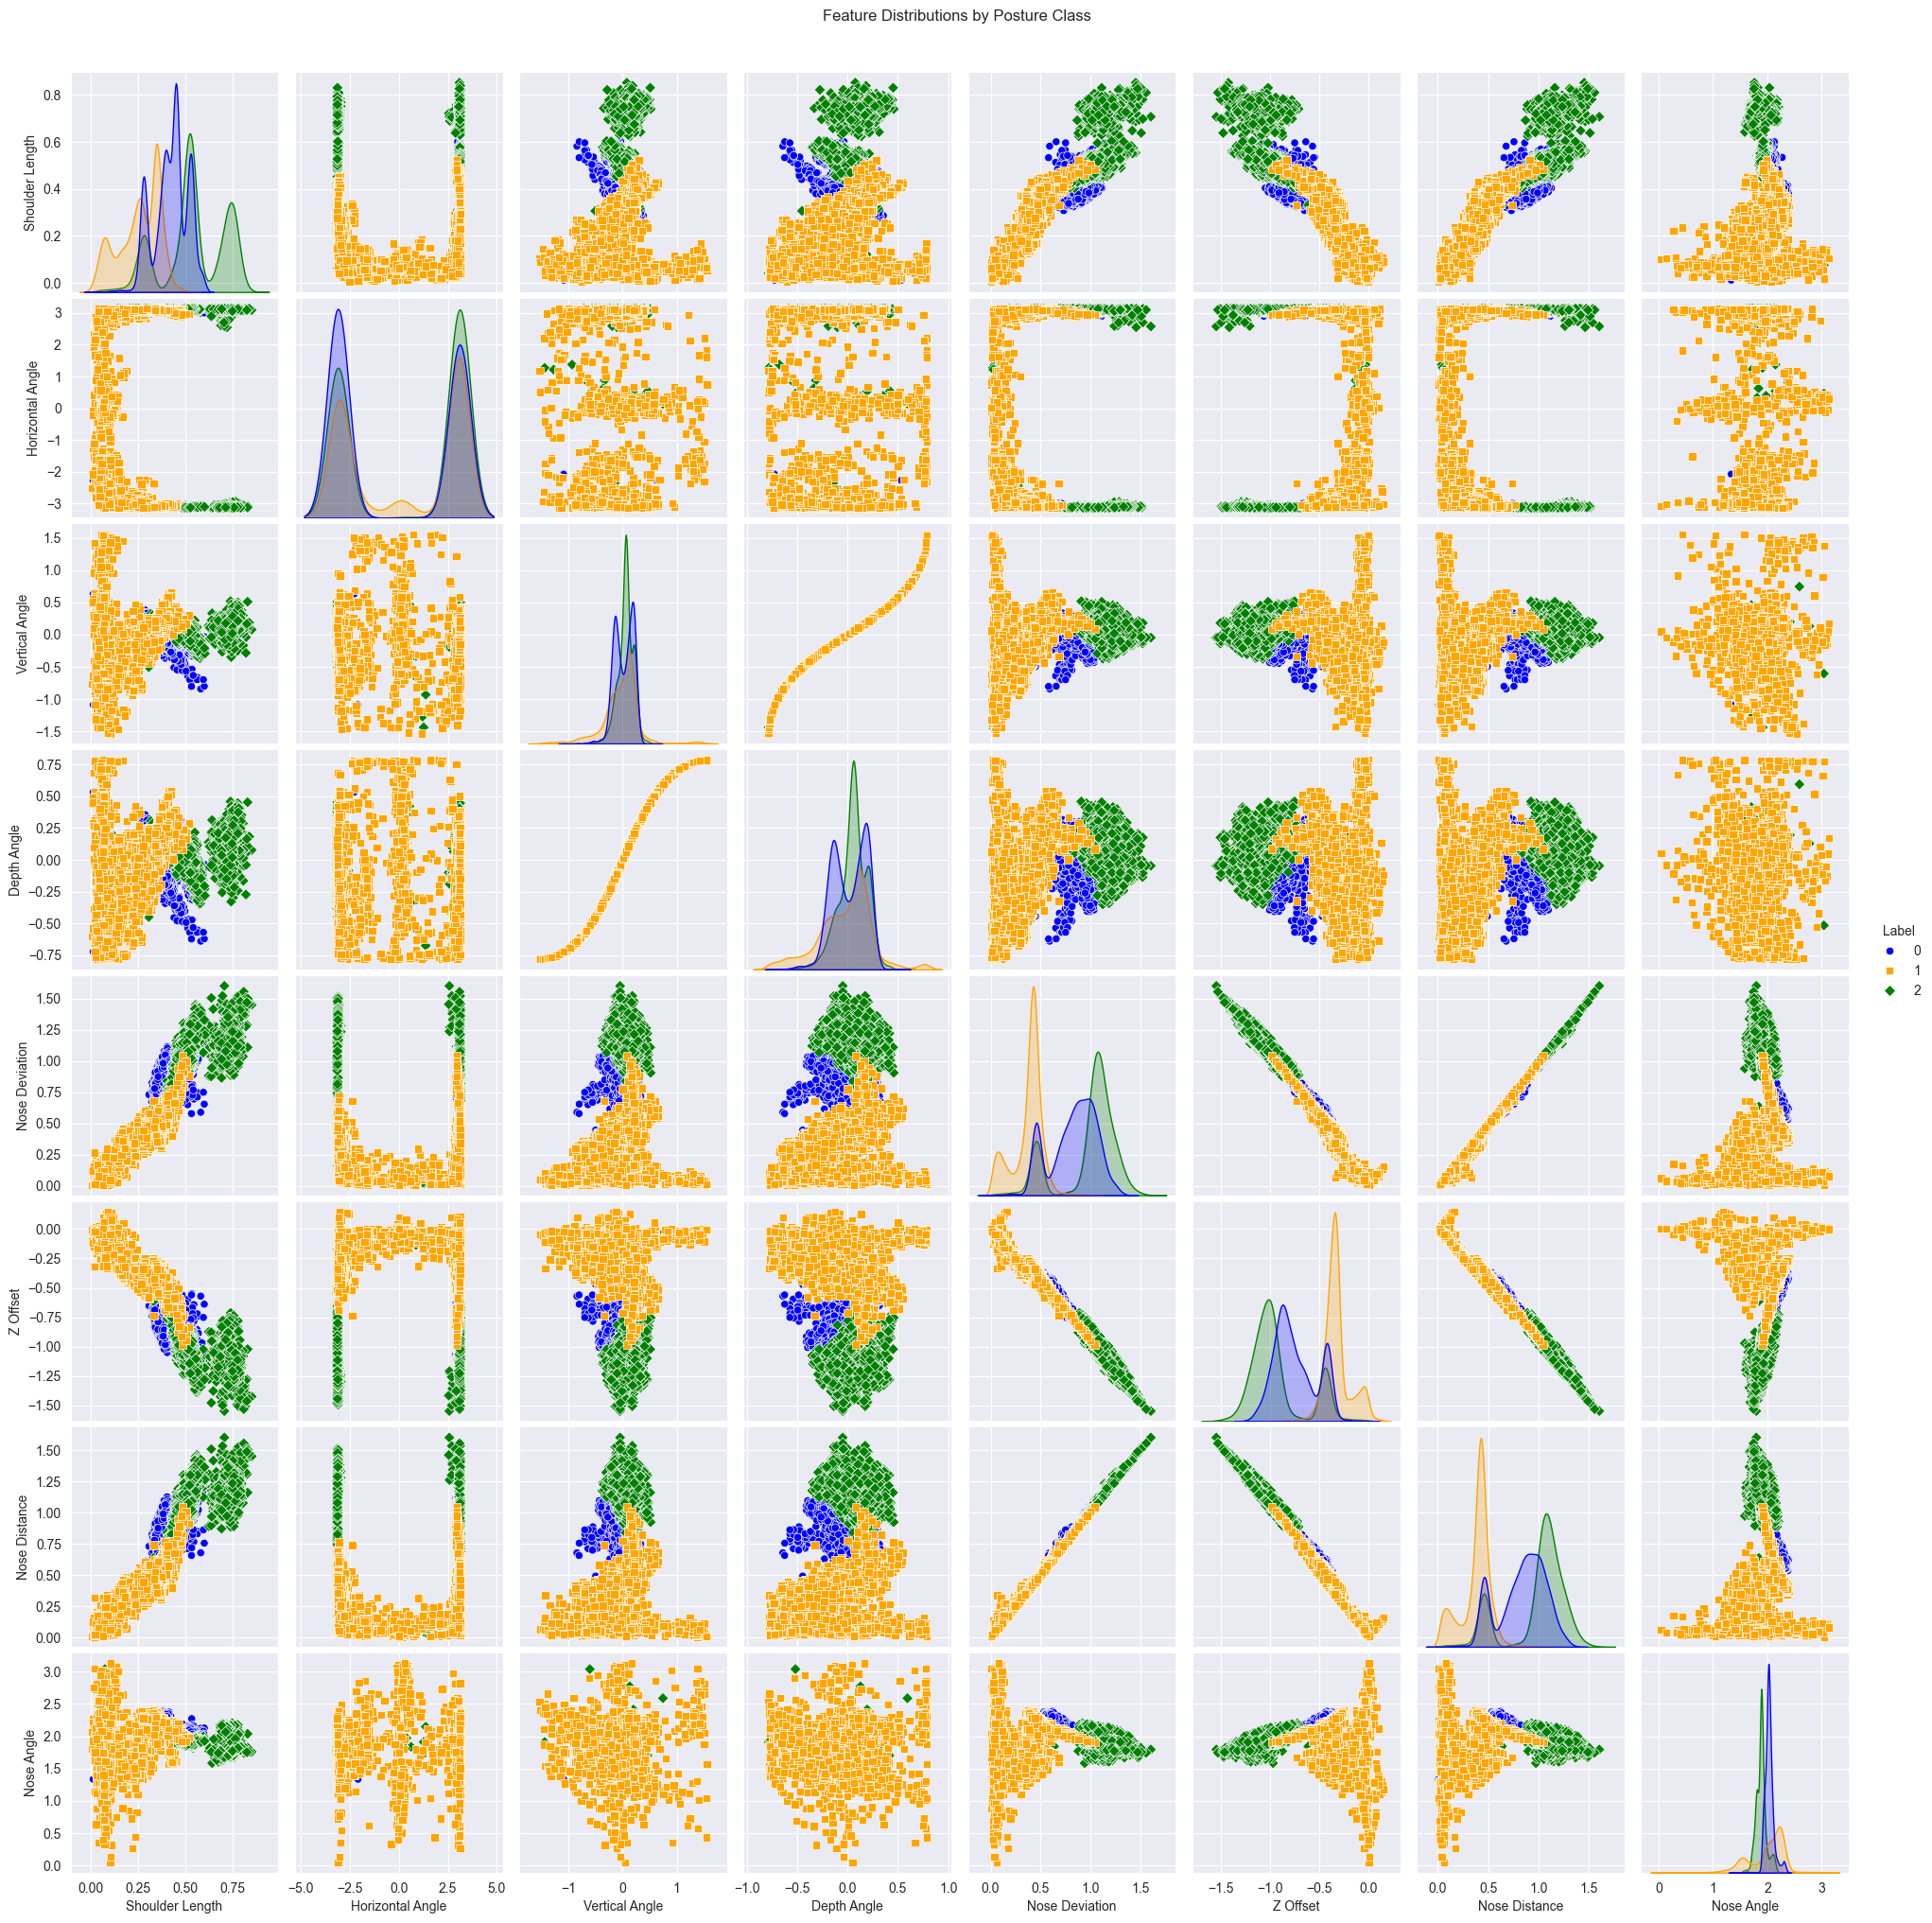

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Combine features and labels into a DataFrame
feature_names = [
    "Shoulder Length",
    "Horizontal Angle",
    "Vertical Angle",
    "Depth Angle",
    "Nose Deviation",
    "Z Offset",
    "Nose Distance",
    "Nose Angle"
]
train_df = pd.DataFrame(X_train, columns=feature_names)
train_df['Label'] = y_train

# Pairplot of feature distributions by class
sns.pairplot(
    train_df,
    hue='Label',
    palette={0: 'blue', 1: 'orange', 2: 'green'},
    diag_kind='kde',
    markers=['o', 's', 'D']
)
plt.suptitle('Feature Distributions by Posture Class', y=1.02)
plt.show()


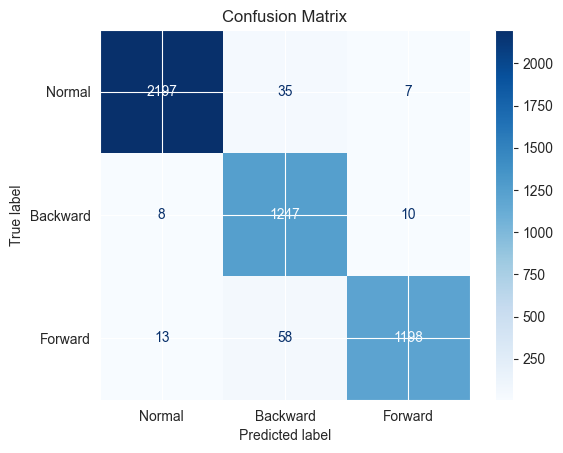

In [8]:
from sklearn.metrics import ConfusionMatrixDisplay

# Plot confusion matrix
cm_display = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, display_labels=['Normal', 'Backward', 'Forward'], cmap='Blues'
)
cm_display.ax_.set_title("Confusion Matrix")
plt.show()


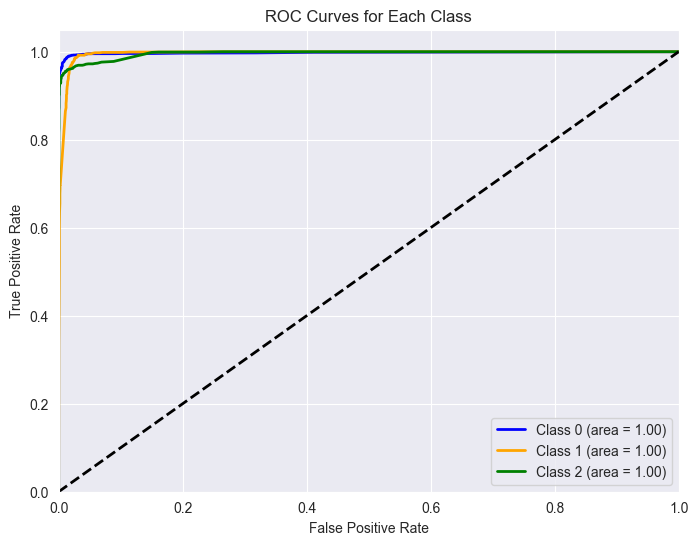

In [9]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier

# Binarize labels for multi-class ROC
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_binarized.shape[1]

# Train One-vs-Rest classifier
clf = OneVsRestClassifier(RandomForestClassifier(random_state=42))
clf.fit(X_train_scaled, label_binarize(y_train, classes=[0, 1, 2]))
y_score = clf.predict_proba(X_test_scaled)

# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))
colors = ['blue', 'orange', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"Class {i} (area = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc="lower right")
plt.show()


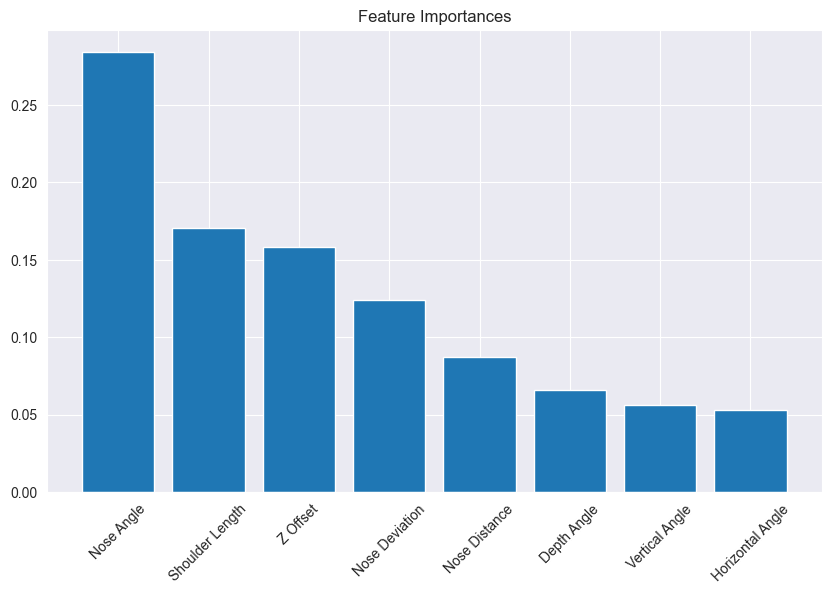

In [10]:
# Feature importances from the Random Forest classifier
importances = clf.estimators_[0].feature_importances_
sorted_indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[sorted_indices], align='center')
plt.xticks(range(len(importances)), [feature_names[i] for i in sorted_indices], rotation=45)
plt.title('Feature Importances')
plt.show()


Misclassified Frame Indices: [  20   28  107  108  162  197  205  308  383  490  503  570  572  582
  722  747  766  777  808  881  962 1010 1219 1248 1299 1328 1410 1423
 1432 1563 1803 1876 1924 1952 1963 1967 1979 2063 2086 2112 2121 2138
 2239 2258 2273 2337 2362 2373 2377 2381 2401 2415 2444 2472 2481 2491
 2499 2518 2522 2564 2608 2613 2616 2628 2633 2640 2653 2660 2671 2699
 2744 2747 2756 2759 2764 2787 2795 2852 2862 2869 2877 2889 2924 2952
 2991 2994 3007 3027 3030 3080 3094 3112 3118 3131 3193 3209 3229 3258
 3283 3291 3360 3369 3381 3386 3397 3406 3414 3420 3422 3471 3488 3500
 3504 3573 3708 3731 3868 3965 4004 4080 4093 4100 4105 4198 4243 4262
 4280 4386 4526 4533 4549]


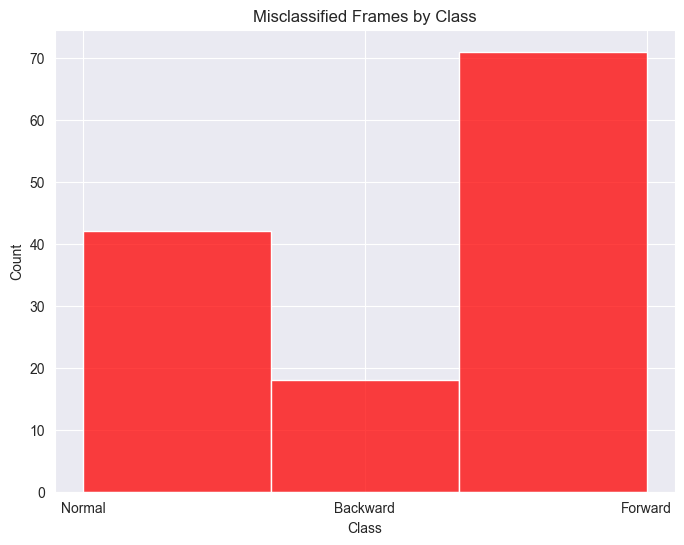

In [11]:
# Identify misclassified frames
misclassified_indices = np.where(y_pred != y_test)[0]

# Print misclassified frame indices
print("Misclassified Frame Indices:", misclassified_indices)

# Histogram of misclassified frames by class
misclassified_labels = y_test[misclassified_indices]
plt.figure(figsize=(8, 6))
sns.histplot(misclassified_labels, bins=3, kde=False, color='red')
plt.title('Misclassified Frames by Class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2], labels=['Normal', 'Backward', 'Forward'])
plt.show()


In [12]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

# Apply RFE for dimensionality reduction
rfe = RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=4)
rfe.fit(X_train, y_train)

# Get selected features
selected_features = [feature_names[i] for i in range(len(feature_names)) if rfe.support_[i]]
print("Selected Features via RFE:", selected_features)

# Transform the data to reduced dimensions
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)


Selected Features via RFE: ['Shoulder Length', 'Nose Deviation', 'Z Offset', 'Nose Angle']


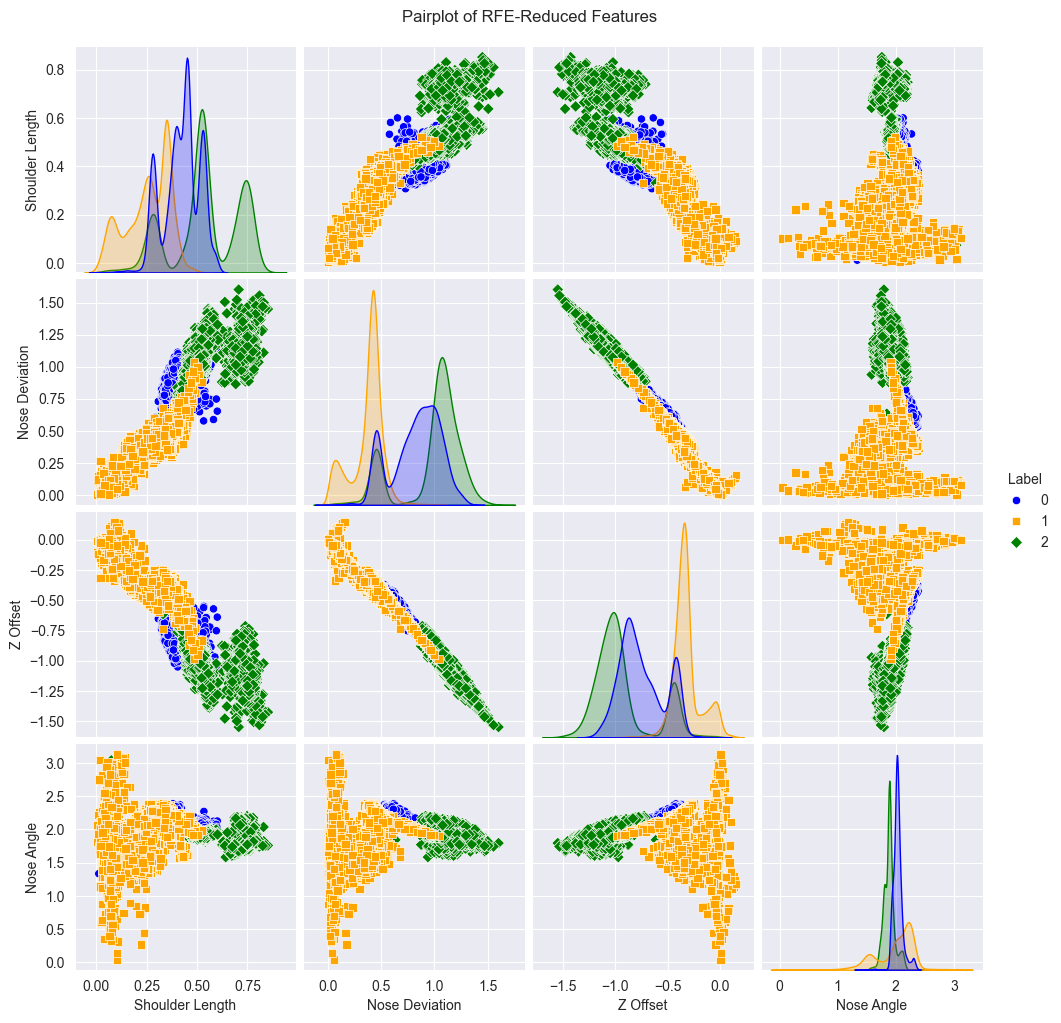

In [13]:
# Combine features and labels into a DataFrame
rfe_df = pd.DataFrame(X_train_rfe, columns=selected_features)
rfe_df['Label'] = y_train  # Add labels for coloring

# Generate a pairplot for the reduced features
sns.pairplot(
    rfe_df,
    hue='Label',
    palette={0: 'blue', 1: 'orange', 2: 'green'},
    diag_kind='kde',
    markers=['o', 's', 'D']
)
plt.suptitle('Pairplot of RFE-Reduced Features', y=1.02)
plt.show()


In [15]:
from sklearn.impute import SimpleImputer

# Impute missing values in training and testing data
imputer = SimpleImputer(strategy='mean')  # Replace 'mean' with 'median' if needed
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)


In [16]:
# Remove rows with NaN values
mask_train = ~np.isnan(X_train).any(axis=1)
X_train = X_train[mask_train]
y_train = y_train[mask_train]

mask_test = ~np.isnan(X_test).any(axis=1)
X_test = X_test[mask_test]
y_test = y_test[mask_test]


Explained Variance by PCA Components: [0.94861355 0.0366271  0.0097496  0.00440986]


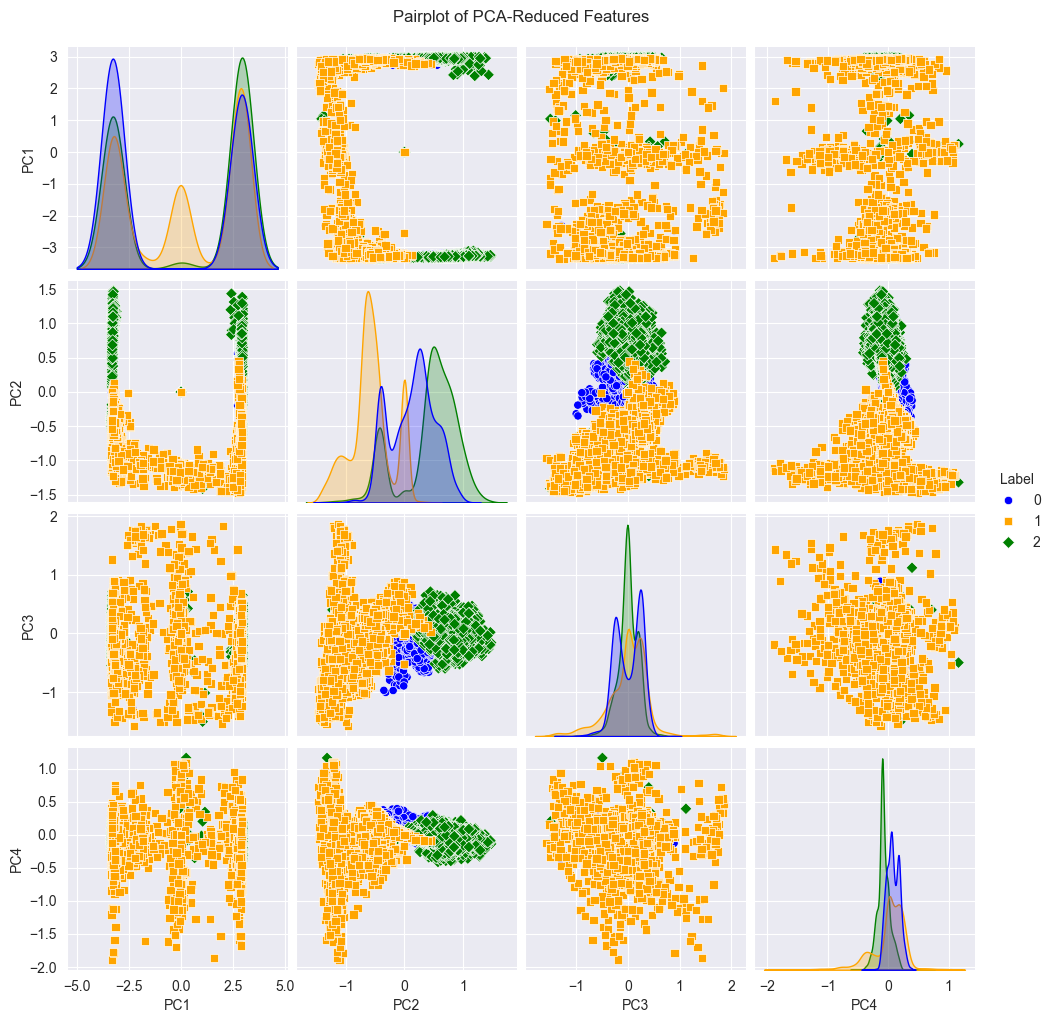

In [17]:
from sklearn.decomposition import PCA

# Apply PCA after preprocessing
pca = PCA(n_components=4)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Print explained variance ratios
explained_variance = pca.explained_variance_ratio_
print("Explained Variance by PCA Components:", explained_variance)

# Create a DataFrame for PCA components
pca_columns = [f"PC{i+1}" for i in range(X_train_pca.shape[1])]
pca_df = pd.DataFrame(X_train_pca, columns=pca_columns)
pca_df['Label'] = y_train

# Pairplot for PCA components
sns.pairplot(
    pca_df,
    hue='Label',
    palette={0: 'blue', 1: 'orange', 2: 'green'},
    diag_kind='kde',
    markers=['o', 's', 'D']
)
plt.suptitle('Pairplot of PCA-Reduced Features', y=1.02)
plt.show()


In [18]:
# Train and evaluate using RFE-reduced features
clf_rfe = RandomForestClassifier(random_state=42)
clf_rfe.fit(X_train_rfe, y_train)
y_pred_rfe = clf_rfe.predict(X_test_rfe)
print("Classification Report (RFE-Reduced):")
print(classification_report(y_test, y_pred_rfe))

# Train and evaluate using PCA-reduced features
clf_pca = RandomForestClassifier(random_state=42)
clf_pca.fit(X_train_pca, y_train)
y_pred_pca = clf_pca.predict(X_test_pca)
print("Classification Report (PCA-Reduced):")
print(classification_report(y_test, y_pred_pca))


Classification Report (RFE-Reduced):
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2239
           1       0.93      0.97      0.95      1265
           2       0.98      0.94      0.96      1269

    accuracy                           0.97      4773
   macro avg       0.96      0.96      0.96      4773
weighted avg       0.97      0.97      0.97      4773

Classification Report (PCA-Reduced):
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      2239
           1       0.91      0.98      0.95      1265
           2       0.96      0.94      0.95      1269

    accuracy                           0.96      4773
   macro avg       0.95      0.96      0.95      4773
weighted avg       0.96      0.96      0.96      4773



In [20]:
pwd

'/Users/idrissunmola/Documents/Idris_macbook/Fall_24/ml_proj/SitSmartBackend/notebook'

In [19]:
# Save RFE-reduced features and labels
np.save('reduced_features_rfe.npy', X_train_rfe)  # Training features (RFE)
np.save('reduced_features_rfe_test.npy', X_test_rfe)  # Testing features (RFE)
np.save('labels_rfe_train.npy', y_train)  # Training labels (RFE)
np.save('labels_rfe_test.npy', y_test)  # Testing labels (RFE)

# Save PCA-reduced features and labels
np.save('reduced_features_pca.npy', X_train_pca)  # Training features (PCA)
np.save('reduced_features_pca_test.npy', X_test_pca)  # Testing features (PCA)
np.save('labels_pca_train.npy', y_train)  # Training labels (PCA)
np.save('labels_pca_test.npy', y_test)  # Testing labels (PCA)

print("Reduced datasets and labels saved successfully!")


Reduced datasets and labels saved successfully!


In [ ]:
#Evaluations

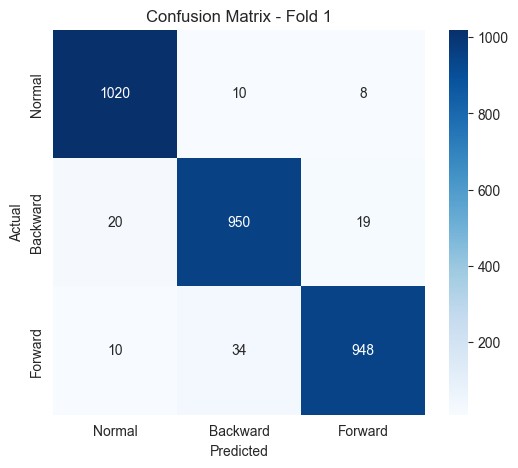

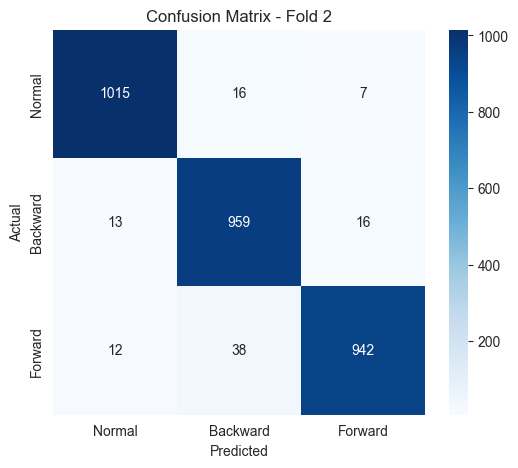

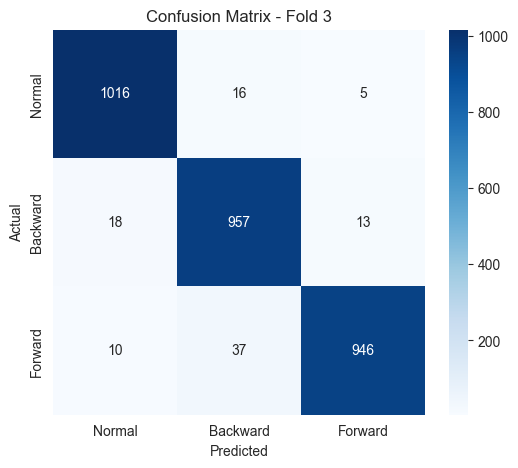

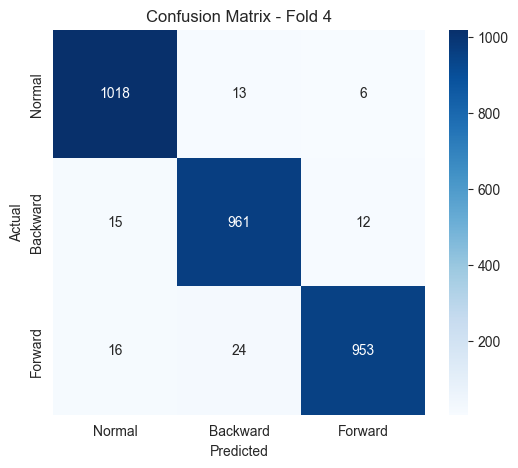

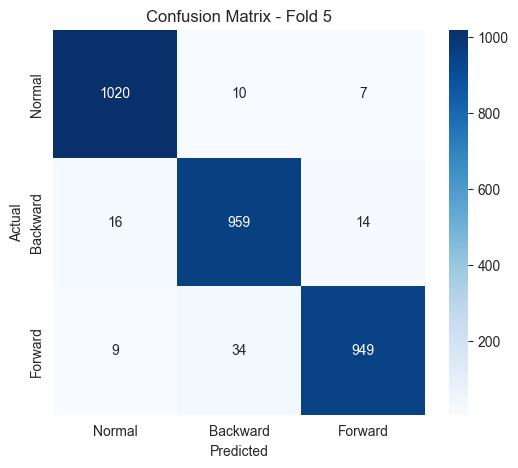

In [21]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def stratified_k_fold_evaluation(X, y, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_reports = []
    fold_conf_matrices = []

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        # Split the data
        X_train_cv, X_test_cv = X[train_idx], X[test_idx]
        y_train_cv, y_test_cv = y[train_idx], y[test_idx]

        # Train the classifier
        clf = RandomForestClassifier(random_state=42)
        clf.fit(X_train_cv, y_train_cv)

        # Evaluate
        y_pred_cv = clf.predict(X_test_cv)
        report = classification_report(y_test_cv, y_pred_cv, output_dict=True)
        cm = confusion_matrix(y_test_cv, y_pred_cv)

        fold_reports.append(report)
        fold_conf_matrices.append(cm)

        # Visualization
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=["Normal", "Backward", "Forward"],
                    yticklabels=["Normal", "Backward", "Forward"])
        plt.title(f"Confusion Matrix - Fold {fold + 1}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

    return fold_reports, fold_conf_matrices


rfe_reports, rfe_matrices = stratified_k_fold_evaluation(X_train_rfe, y_train)


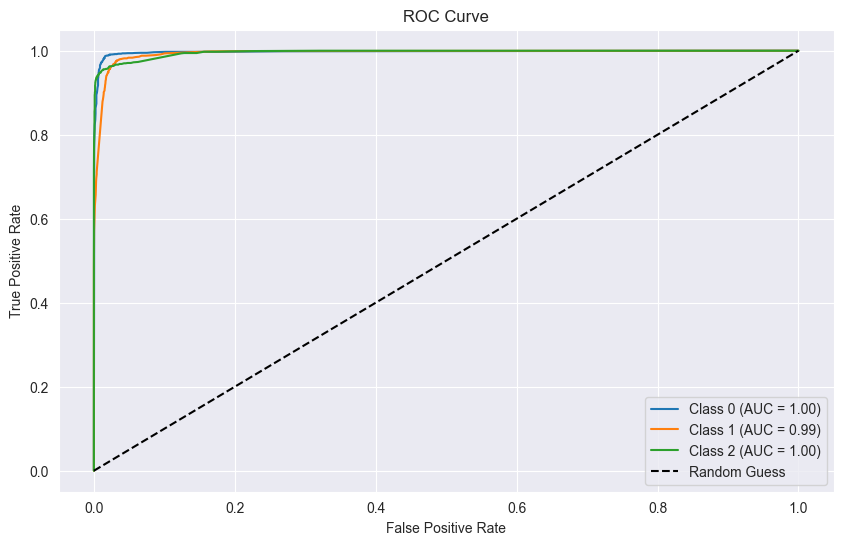

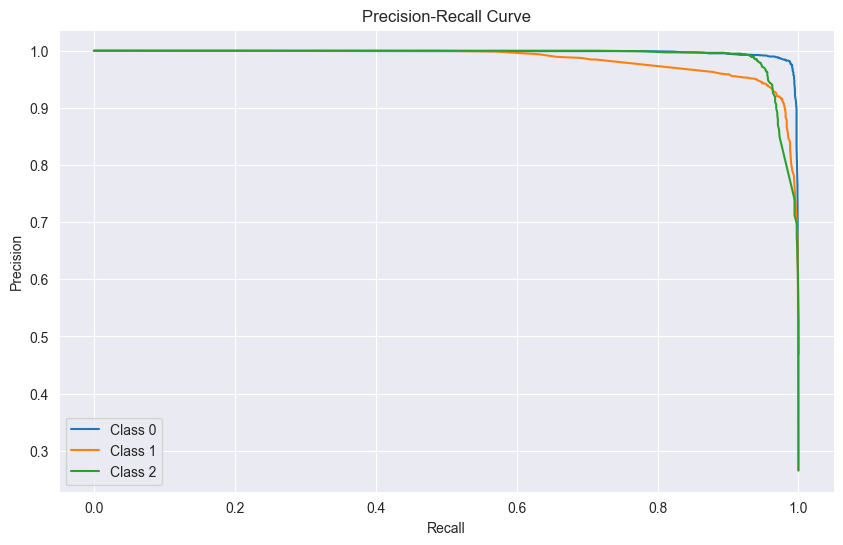

In [23]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

def plot_roc_and_pr_curves(X_train, X_test, y_train, y_test, n_classes=3):
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_test)

    # Plot ROC Curve
    plt.figure(figsize=(10, 6))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test == i, y_prob[:, i])
        plt.plot(fpr, tpr, label=f"Class {i} (AUC = {auc(fpr, tpr):.2f})")
    plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

    # Plot Precision-Recall Curve
    plt.figure(figsize=(10, 6))
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(y_test == i, y_prob[:, i])
        plt.plot(recall, precision, label=f"Class {i}")
    plt.title("Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.show()

plot_roc_and_pr_curves(X_train_rfe, X_test_rfe, y_train, y_test, n_classes=3)


/var/folders/s2/b2sgp89x16bgqv6slp_s_lxm0000gn/T/ipykernel_53771/32738803.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(feature_importances, labels=selected_features, vert=False)


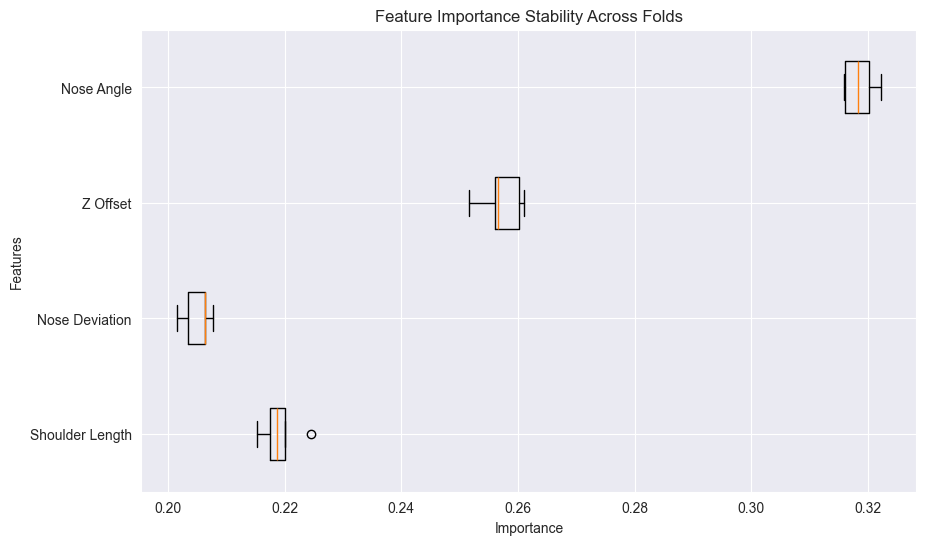

In [26]:
def feature_importance_stability_safe(X, y, n_splits=5):
    # Ensure dimensions match
    assert X.shape[0] == y.shape[0], "Mismatch between X and y dimensions."
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    feature_importances = np.zeros((n_splits, X.shape[1]))

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        clf = RandomForestClassifier(random_state=42)
        clf.fit(X[train_idx], y[train_idx])
        feature_importances[fold] = clf.feature_importances_

    # Plot feature importance stability
    plt.figure(figsize=(10, 6))
    plt.boxplot(feature_importances, labels=selected_features, vert=False)
    plt.title("Feature Importance Stability Across Folds")
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.show()

feature_importance_stability_safe(X_train_rfe, y_train)


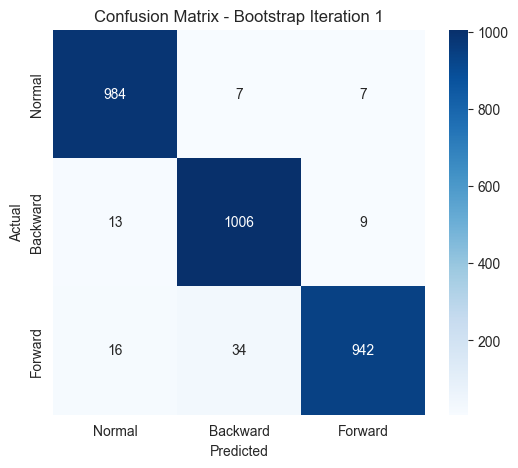

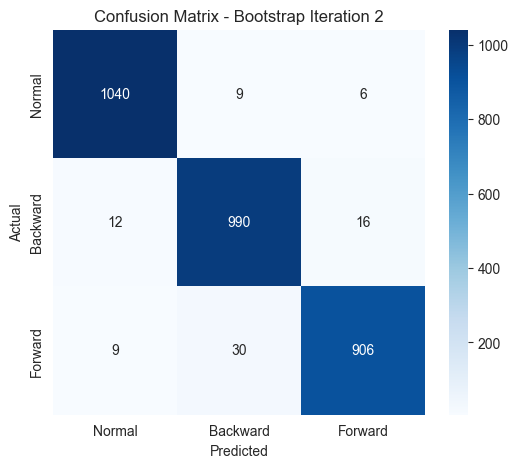

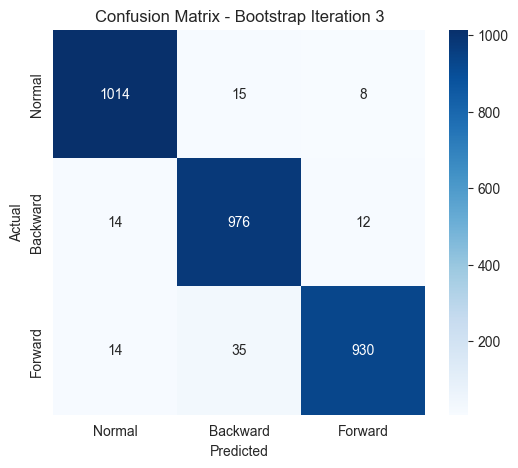

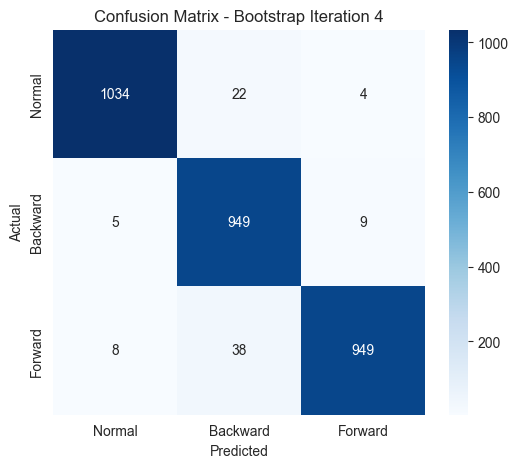

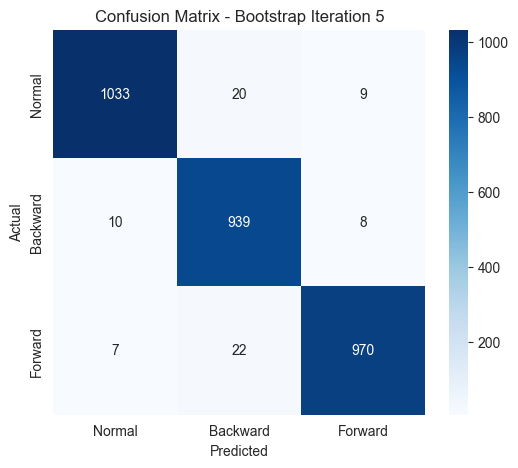

In [27]:
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix

def bootstrap_evaluation(X, y, n_iterations=100, test_size=0.2):
    reports = []
    for i in range(n_iterations):
        # Bootstrap sampling
        X_train, y_train = resample(X, y, replace=True, n_samples=int((1 - test_size) * len(y)), random_state=i)
        X_test, y_test = resample(X, y, replace=False, n_samples=int(test_size * len(y)), random_state=i)

        # Train the classifier
        clf = RandomForestClassifier(random_state=42)
        clf.fit(X_train, y_train)

        # Evaluate
        y_pred = clf.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True)
        cm = confusion_matrix(y_test, y_pred)

        reports.append(report)

        if i < 5:  # Plot confusion matrices for the first few iterations
            plt.figure(figsize=(6, 5))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                        xticklabels=["Normal", "Backward", "Forward"],
                        yticklabels=["Normal", "Backward", "Forward"])
            plt.title(f"Confusion Matrix - Bootstrap Iteration {i + 1}")
            plt.xlabel("Predicted")
            plt.ylabel("Actual")
            plt.show()

    return reports

bootstrap_reports = bootstrap_evaluation(X_train_rfe, y_train)


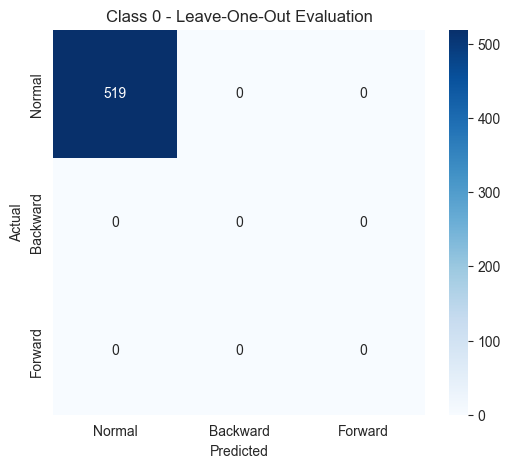

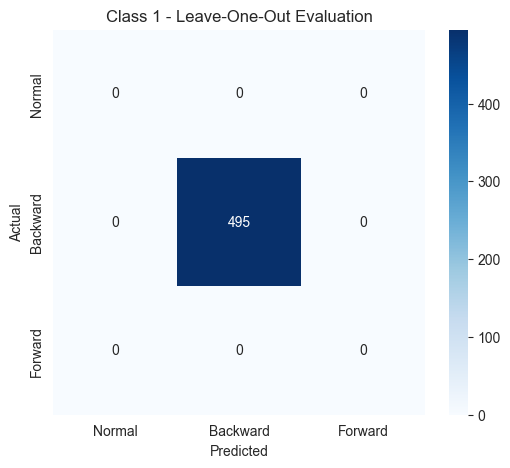

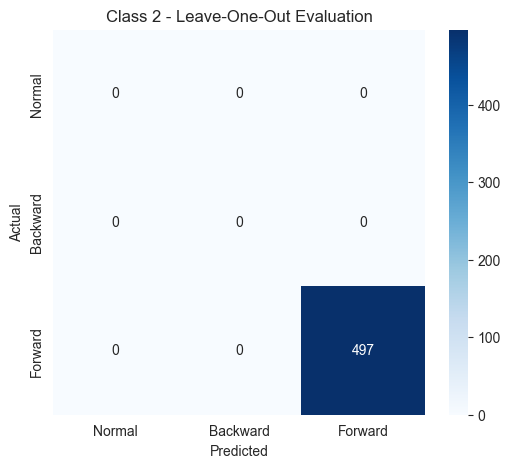

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def class_specific_leave_one_out(X, y, test_fraction=0.1):
    class_reports = []
    known_labels = np.unique(y)  # Get all possible labels

    for class_label in known_labels:
        # Split the data for this class
        X_class = X[y == class_label]
        y_class = y[y == class_label]

        X_train, X_test, y_train, y_test = train_test_split(X_class, y_class, test_size=test_fraction, random_state=42)

        # Train on the rest of the data
        clf = RandomForestClassifier(random_state=42)
        clf.fit(X_train, y_train)

        # Evaluate on the test set for this class
        y_pred = clf.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

        # Confusion matrix with known labels
        cm = confusion_matrix(y_test, y_pred, labels=known_labels)

        class_reports.append(report)

        # Visualization
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=["Normal", "Backward", "Forward"],
                    yticklabels=["Normal", "Backward", "Forward"])
        plt.title(f"Class {class_label} - Leave-One-Out Evaluation")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

    return class_reports

class_specific_reports = class_specific_leave_one_out(X_train_rfe, y_train)


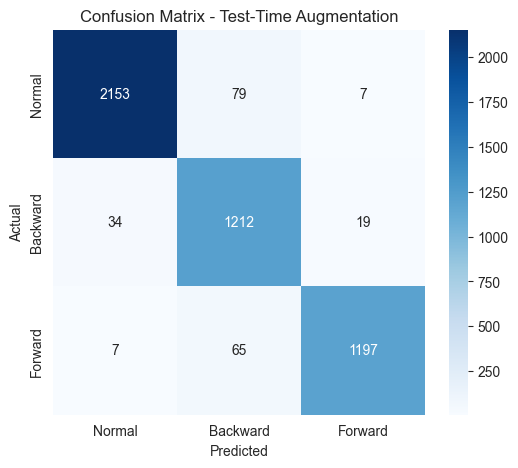

In [29]:
from sklearn.metrics import classification_report, confusion_matrix

def test_time_augmentation_evaluation(X_test, y_test, augmentations):
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train_rfe, y_train)

    augmented_predictions = []
    for aug in augmentations:
        # Apply augmentation
        X_augmented = aug(X_test)

        # Predict
        y_pred = clf.predict(X_augmented)
        augmented_predictions.append(y_pred)

    # Aggregate predictions (majority vote)
    y_pred_final = np.array(augmented_predictions).mean(axis=0).round().astype(int)

    # Evaluation
    report = classification_report(y_test, y_pred_final, output_dict=True)
    cm = confusion_matrix(y_test, y_pred_final)

    # Visualization
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Normal", "Backward", "Forward"],
                yticklabels=["Normal", "Backward", "Forward"])
    plt.title("Confusion Matrix - Test-Time Augmentation")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return report

augmentations = [lambda x: x, lambda x: x + np.random.normal(0, 0.01, x.shape)]
tta_report = test_time_augmentation_evaluation(X_test_rfe, y_test, augmentations)
